# Preprocessing

This notebook demonstrates steps required to cleanup the texts, including:

- convert to lowercase.
- remove punctuations and numbers
- tokenize
- remove stopwords
- stemming
- lemmatize
- n-gram

In doing so, I will also expriment with standard pipelines such as NLTK, Gensim, and SpaCy preprocessing pipelines.

## Custom preprocessing (NLTK)

The following code aims to verify the quality of corpus using a bare bone off-the-shelf preprocessing pipelines. I will use NLTK and Gensim here because of their popularity and possible reproducability.

In [52]:
import nltk
import string   # for punctuation symbols.
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')#, '../data/cache/nltk')
nltk.download('stopwords')#, '../data/cache/nltk')
nltk.download('punkt')

# example list of raw texts
TEXTS = ['executive functions are cool!', 'cognitive control contains 9 sub-components!']

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()


def preprocess(doc):
    # 1. lowercase
    doc = doc.lower()
    # 2. remove punctuations (TODO: and numbers)
    doc = ''.join([c for c in doc if c not in string.punctuation])
    # 3. tokenize
    doc = nltk.word_tokenize(doc)
    # 4. remove stopwords
    doc = [w for w in doc if w not in stop_words]
    # 5. stem
    # doc = [stemmer.stem(w) for w in doc]
    # 6. lemmatize
    doc = [lemmatizer.lemmatize(w) for w in doc]
    return doc

# method 1
[preprocess(txt) for txt in TEXTS]

# method 2 (gensim)
from gensim.parsing import preprocess_documents
preprocess_documents(TEXTS)


[nltk_data] Downloading package wordnet to /Users/morteza/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/morteza/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/morteza/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[['execut', 'function', 'cool'],
 ['cognit', 'control', 'contain', 'sub', 'compon']]

## Gensim standard preprocessing pipeline

The following code loads **Stroop** test corpus and perform the standard preprocessing pipeline on abstracts. The new tokenized texts are stored in the `preprocessed_abstract`.

In [50]:
from gensim.parsing import preprocess_documents, preprocess_string
import pandas as pd

df = pd.read_csv('../data/pubmed/tests/Stroop.csv')
df['abstract'].fillna(df['title'], inplace=True)

df['preprocessed_abstract'] = df['abstract'].apply(lambda abstract: preprocess_string(abstract))
# %timeit preprocess_documents(df['abstract'].to_list())

# Note: both of the above methods preprocess the corpus at the same speed (checked with %timeit)

# DEBUG data check: df['preprocessed_abstract'], df.loc[0,'preprocessed_abstract']

## SpaCy preprocessing pipeline

SpaCy provides a more comperhensive preprocessing pipeline that allowed more complex text processing such as additional stop-words, n-gram analysis, and taking into account the connector words.

In [1]:
import pandas as pd
import spacy
import gensim
from gensim.corpora import Dictionary
from gensim.models import HdpModel
from gensim.models.phrases import ENGLISH_CONNECTOR_WORDS
from spacy import displacy


# Example TEXTS
# TEXTS = ['Hello tweleve (12) executive functions tasks from New york',
        #  'this is however New York-based experiement that measures executive function']

df = pd.read_csv('data/pubmed/tests/Anti-Saccade Task.csv')
df['abstract'].fillna(df['title'], inplace=True)
TEXTS = df['abstract'].to_list()

# python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')

# additional stopwords
my_stop_words = ['study','task','test']
for stop_word in my_stop_words:
    lexeme = nlp.vocab[stop_word]
    lexeme.is_stop = True


def clean(doc):
    words = []
    for w in doc:
        if not w.is_stop and not w.is_punct and not w.like_num and not w.is_space:
            words.append(w.lemma_)
    return words

docs = [clean(d) for d in nlp.pipe(TEXTS)]

# common_terms = ["of", "with", "without", "and", "or", "the", "a"]
bigram_phrases = gensim.models.Phrases(docs, connector_words=ENGLISH_CONNECTOR_WORDS)
trigram_phrases = gensim.models.Phrases(bigram_phrases[docs], connector_words=ENGLISH_CONNECTOR_WORDS)

ngram = gensim.models.phrases.Phraser(trigram_phrases)
docs = list(ngram[docs])

In [ ]:
# word2vec

# dictionary = Dictionary(docs)
# corpus = [dictionary.doc2bow(d) for d in docs]

# model = HdpModel(corpus=corpus, id2word=dictionary)
# model.show_topics()


# TODO grid tune on vector_size
model = gensim.models.Word2Vec(docs, min_count=3, vector_size=200, workers=4, window=5)

# most similar (top ten)
model.wv.most_similar('anti_saccade', topn=10)
# similarity
model.wv.similarity('anti_saccade','stroop')
# odd one out
model.wv.doesnt_match(['anti_saccade', 'stroop', 'n-back'])


# TODO TSNE of most similar and most dissimmilar terms to the task term

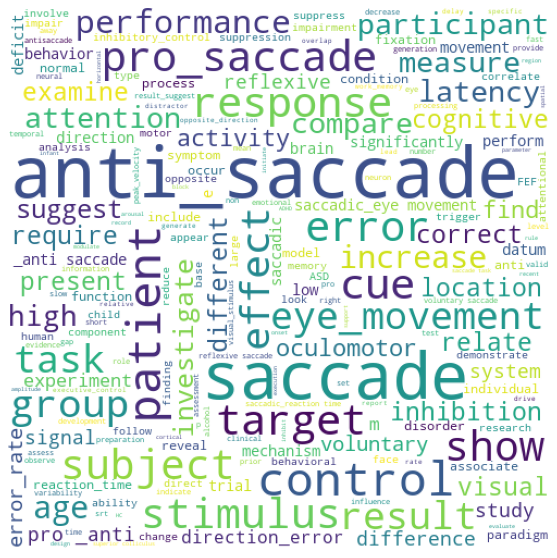

In [13]:
# word cloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud(docs):
    wc_corpus = ' '.join([' '.join(doc) for doc in docs])
    cloud = WordCloud(width=500,height=500,background_color ='white').generate(wc_corpus)

    plt.figure(figsize=(10,10))
    plt.imshow(cloud)
    plt.axis('off')

plot_wordcloud(docs)
plt.show()